# The Data Science Pipeline

## 1. Introduction
This tutorial will walk you through a whole process of the Data Science Pipeline, which includes (1) *Data collection*, (2) *Data representation*, (3) *Exploratory data analysis*, (4) *Hypothesis testing and machine learning*, and (5) *Communication of insights attained*. The dataset we chose is the data related to India financial market. This is because we interests in the topic about Indian financial market, and trying to explore the relationships between the India stock market and (a) India's GDP, (b) India's interest rate, (c) India's exchange rate, as well as (d) the U.S's stock market index. In the next tutorail, we will first load the data from several sources; secondly tidy the datasets and deal with missing values; thirdly, perform exploratory data analysis (EDA); fourthly, examine the relations which are found in last step (EDA) using Hypothesis Testing; and lastly, build a Machine Learning model to predict the India's stock market index. The India financial market topic will help us to go through the Data Science Pipeline, hope you enjoy it!

## 2. Set Up
To perform this data analysis, some libaries will be highly useful in the following steps. Significantly, *pandas* will help us to import data and carry out some data pre-processing, *numpy* is expert at mitrix calcualtion, *matplotlib.pyplot* provides a MATLAB-like way of plotting, and *sklearn* features various classification, regression and clustering algorithms including support vector machines, random forests, gradient boosting, k-means and DBSCAN.

In [240]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from statsmodels.formula.api import logit
import statsmodels.api as sm
import re
import sklearn.ensemble
import sklearn.model_selection
import sklearn.metrics
import sklearn.linear_model
plt.style.use('seaborn')

## 3. Loading Data
The data we used in this tutorial is mainly from 5 socuses, \
(1) NIFTY 500 Index (2000-2019) -- **a_nifty500index**, which is the India's stock market index data. In other words, it is the data we would like to predict. There are a lot of features/columns in this table but we only use the *close value* column. \
(2) GDP PPP of India (2000-2019) -- **b_GDP**, which is the India's GDP data. This table contains all countries' GDP information while we only take the India ones. \
(3) Real interest rate of India (2000-2019) -- **c_realInterestRate**, which is the India's interest rate data.
(4) The exchange rate of the Indian Rupee(INR)(2000-2019) -- **d_exchangeRate**, which is the India's exchange rate data. \
(5) The S & P 500 Index (2000-2019) -- **e_SP500index**, pick the SP500 column from this table as the U.S's stock market index. 

In [191]:
# India stock market
a_nifty500index = pd.read_csv('dataset/a_NIFTY 500 Index (2000-2019).csv')
# GDP
b_GDP = pd.read_csv('dataset/b_GDP PPP of India (2000-2019).csv')
# interest rate
c_realInterestRate = pd.read_csv('dataset/c_Real interest rate of India (2000-2019).csv')
# exchange rate
d_exchangeRate = pd.read_csv('dataset/d_The exchange rate of the Indian Rupee(INR)(2000-2018)_annual.csv')
# US stock market
e_SP500index = pd.read_csv('dataset/e_The S & P 500 Index (2000-2019).csv')

## 4. Tidy Data
### 4.1. Feature Selection
According to the section 3, we do not need to include all columns in those tables. To simplify the data, we only keep the data we needed. Note that we will keep all Date columns in each table since they will help us to join these tables together.\
For a_nifty500index, only take columns *Date* and *Close*. Select *Date* and *SP500* in table e_SP500index, also consider the data should start from 2000. It becomes a little bit tricky when it comes to b_GDP, we first select the row related to India, then transpose the table, and lastly pick *year* and *gdp* columns. Roughly the same situation of c_realInterestRate with b_GDP, except that the years need to be extracted from strings. Lastly, in case of d_exchangeRate, no column selection need to be performed since it contains only the features we wanted. 

In [192]:
# only take Columns 'Date' and 'Close'
a_nifty500index = a_nifty500index[['Date', 'Close']]
# only take 'Date' and 'SP500', also the data should start from 2000.
e_SP500index = e_SP500index[['Date', 'SP500']][e_SP500index['Date']>'2000']

In [193]:
# select row
b_GDP = b_GDP[b_GDP['Country ']=='India'].T[2:].reset_index()
# create year column
b_GDP['year'] = b_GDP['index']
# create gdp column
b_GDP['gdp'] = b_GDP[103].values
# pick columns
b_GDP = b_GDP[['year', 'gdp']]
# change the datatype of gdp to float
b_GDP = b_GDP.astype({"gdp": float})

In [194]:
c_realInterestRate = c_realInterestRate[c_realInterestRate['Country Name']=='India'].T[5:].reset_index()
c_realInterestRate['year'] =  [x[:4] for x in c_realInterestRate['index'].values]
c_realInterestRate['interestRate'] = c_realInterestRate[0]
c_realInterestRate = c_realInterestRate[['year', 'interestRate']]

In [195]:
d_exchangeRate['year'] = d_exchangeRate['Date']
d_exchangeRate = d_exchangeRate[['year', ' INR/USD-Average']]
d_exchangeRate = d_exchangeRate.astype({"year": str})

### 4.2. Joining tables by year
Before preforming the joining operation, we have to unify some column names to find the connection columns this is, the foreign keys in database.\
To do this, we will add a year column to **a_nifty500index** and **e_SP500index**.

In [196]:
a_nifty500index['year'] = [x[:4] for x in a_nifty500index['Date'].values]
e_SP500index['year'] = [x[:4] for x in e_SP500index['Date'].values]

Firstly, merge a_nifty500index and e_SP500index as all_df by *Date*. We use inner join here because that a_nifty500index and e_SP500index contain most of the data.

In [197]:
all_df = pd.merge(a_nifty500index, e_SP500index, how="inner", on=["Date", "year"])

Then successively merge all_df with b_GDP, c_realInterestRate and d_exchangeRate by *year*.

In [198]:
all_df = pd.merge(all_df, b_GDP, how="left", on=["year"])

In [199]:
all_df = pd.merge(all_df, c_realInterestRate, how="left", on=["year"])
all_df = pd.merge(all_df, d_exchangeRate, how="left", on=["year"])

## 5. Missing Value
In section 4, we talked about that a_nifty500index and e_SP500index are merged by inner join, and then left join with other tables. Therefore, there should be no missing values from a_nifty500index and e_SP500index. In other words, the missing values are mainly caused by columns from 3 other tables. Let check the missing values first.

#### Check Missing values

In [200]:
missing_count_df = pd.DataFrame(all_df.isna().sum(),columns=["#Missing Values"])
missing_count_df

,#Missing Values
Date,0
Close,0
year,0
SP500,0
gdp,0
interestRate,76
INR/USD-Average,0


Only interestRate has 76 missing values. Now we could focus on this specific column. \
(1) Display all posible values of interestR. \
(2) Plot the distribution of interestR.

In [201]:
interestR = all_df[['year', 'interestRate']].drop_duplicates()
interestR

,year,interestRate
0,2000,8.34261
6,2001,NaN
13,2002,NaN
21,2003,NaN
28,2004,NaN
37,2005,NaN
46,2006,NaN
53,2007,NaN
59,2008,NaN
67,2009,NaN


Above table shows that the values of interest rate are missing from 2001 to 2010.

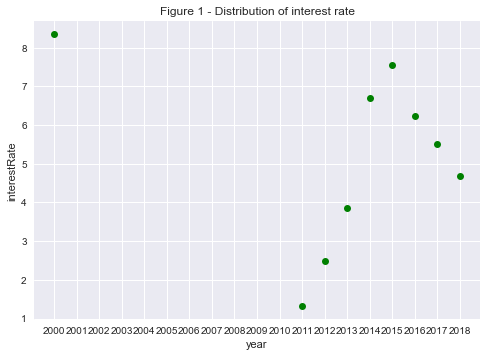

In [202]:
plt.plot(interestR.fillna(0)['year'], interestR['interestRate'], 'go')
plt.title('Figure 1 - Distribution of interest rate')
plt.xlabel('year')
plt.ylabel('interestRate')
plt.show()

Figure 1 shows that the value of the interest rate increases or decreases linearly. Therefore, one possible stratogy to deal with the missing values is to fill them by applying linear interpolation.

In [203]:
# change the datatype of interestRate from object to float
interestR = interestR.astype({"interestRate": float})
# apply linear interpolation
interestR['interestRate'] = interestR[['interestRate']].interpolate(method='linear', limit_direction='both', limit=100)

Join interestR table with all_df by year. Before that, drop the original interestRate column from all_df.

In [204]:
# drop the interestRate column
all_df = all_df.drop('interestRate', axis=1)
# merge interestR and all_df table
all_df = pd.merge(all_df, interestR, how="left", on=['year'])

Check missing value again.

In [205]:
missing_count_df = pd.DataFrame(all_df.isna().sum(),columns=["#Missing Values"])
missing_count_df

,#Missing Values
Date,0
Close,0
year,0
SP500,0
gdp,0
INR/USD-Average,0
interestRate,0


As it shows in above table, there is no missing values in our dataset. Next, we could do some serious data analyzing.

## 6. Exploratory Data Analysis (EDA)
Exploratory Data Analysis is an approach of analyzing data sets to summarize their main characteristics, often using statistical graphics and other data visualization methods. It can be used to detect patterns and make some hypotheses about the data. By applying EDA, we will gain more ideas and information about the data, this could guide us to a further exploration in future.\
In the earlier section, we have mentioned that there are several correlations will be detected in this tutorial. They are\
(1) Nifty 500 vs. GDP PPP India \
(2) Nifty 500 vs. Real Interests Rate of India \
(3) Nifty 500 vs. The Exchange Rate between INR & USD \
(4) Nifty 500 vs. S&P 500. \
In the following part of this section, these correlations will be examined successively.

The matrix below is a Pearson correlation matrix that shows the correlation scores between each columns/variables included in the dataset (all_df). In the matrix, the darker blue boxes represent variables that are highly correlated with each other, while the lighter blue and green boxes represent less correlation scores between variables. Note that above colors all represent possitive correlations. In contrast, the lighter yellow/cream colored boxes represent variables that are negatively correlated. 

[Text(0, 0.5, 'Close'),
 Text(0, 1.5, 'SP500'),
 Text(0, 2.5, 'gdp'),
 Text(0, 3.5, ' INR/USD-Average'),
 Text(0, 4.5, 'interestRate')]

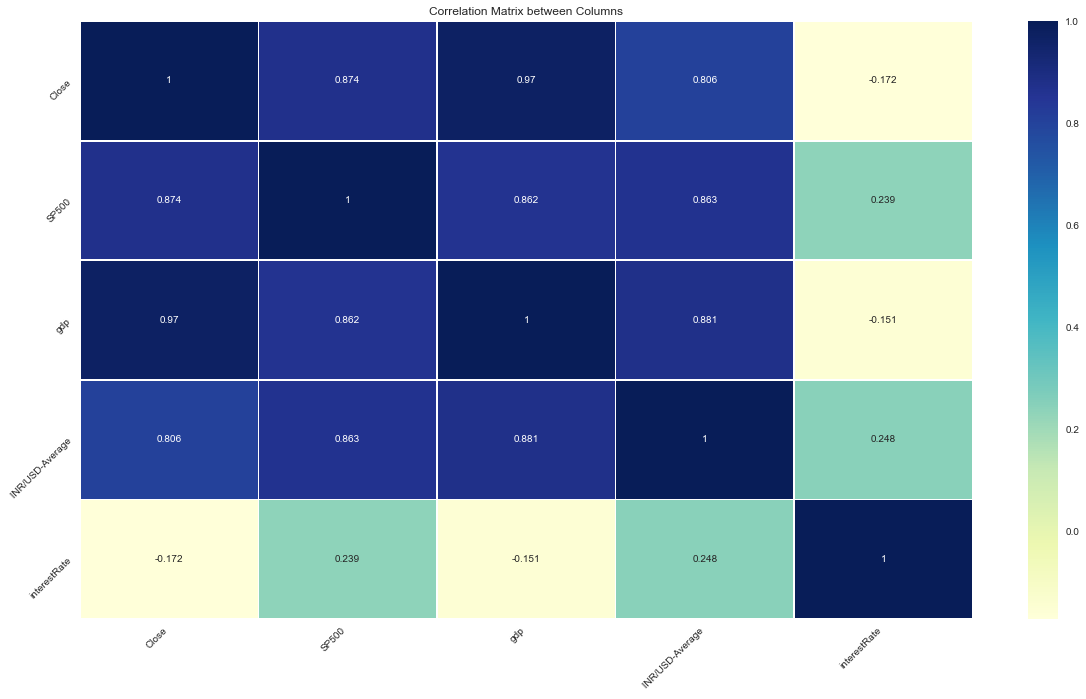

In [212]:
#Correlation Matrix
plt.subplots(figsize = (20,11))
g = sns.heatmap(all_df.corr("pearson"), annot = True, cmap = "YlGnBu", fmt = '.3g', linewidths=.8)

g.set_title("Correlation Matrix between Columns")
g.set_xticklabels(g.get_xticklabels(), rotation=45, horizontalalignment='right')
g.set_yticklabels(g.get_yticklabels(), rotation=45, horizontalalignment='right')

The Pearson correlation matrix shows that **Nifty 500** & **GDP PPP India** got the greatest correlative score, which is **0.97**. In other words, **Nifty 500** & **GDP PPP India** are highly correlated to each other. The Pearson score of **Nifty 500** & **S&P 500** (0.874) is the second highest following by the scores of **Nifty 500** & **the Exchange Rate between INR & USD** (0.806) and **Nifty 500** & **real Interests Rate of India** (-0.172).
We chose to take a closer look at the least correlated variable (**real Interests Rate of India**) in the following Hypothesis testing part.

## 7. Hypothesis Testing
Now, it is the time to perform a hypothesis testing. Hypothesis testing is a statistical method of determining if our created model is a good fit or not. In general, a hypothesis testing will have two hypotheses: a null hypothesis (*Ho*) and an alternative hypothesis (*Ha*). We want to set up our hypothesis such that we reject the null hypothesis (*Ho*). To understand what is the meaning of rejecting the hypothesis, we have to introduce the significance level. When setting up our experiment, in addition to the hypotheses, we set a significance level. If the p value of our random variable in within our significance level, also known as the rejection level, we reject the null hypothesis. While determining whether to reject your null hypothesis or not, be careful to determine what type of test we are setting up; is it one-tailed or two-tailed? 

Take our dataset as an example to provide a clear explanation of Hypothesis testing.\
In our case, we state the significance level as 0.05, and then determe whether there is linear relationship for \
(1) Nifty 500 vs. GDP PPP India \
(2) Nifty 500 vs. Real Interests Rate of India \
(3) Nifty 500 vs. The Exchange Rate between INR & USD \
(4) Nifty 500 vs. S&P 500 \
Note that,  we will most likely to only examine the least related pair (**Nifty 500** & **real Interests Rate of India** *-0.172*) and the second least related pair (**Nifty 500** & **the Exchange Rate between INR & USD** *0.806*) using hypothethejs testing. This is because that the linear relationship of other pairs are self-evident if any of the above two pairs is linear relationship.

#### Test Nifty 500 & real Interests Rate of India is linear relationship
Set up our hypotheses and the significance level\
*alpha = 0.05* (significant level)\
*Ho: There is no linearity between the* **Nifty 500** and **real Interests Rate of India** \
*Ha: There is linearity between the* **Nifty 500** and **real Interests Rate of India** \
Similarly, for the other variables,  we set the corresponding **Ho**s and **Ha**s. We will not repeat the defination of their hypotheses here.

To perform the test, we run a linear regression model to fit our data.

In [268]:
# split depending variables and the output variable.
X = all_df[['SP500', 'gdp', ' INR/USD-Average', 'interestRate']]
model = sm.OLS(all_df['Close'], X)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                  Close   R-squared (uncentered):                   0.991
Model:                            OLS   Adj. R-squared (uncentered):              0.991
Method:                 Least Squares   F-statistic:                              3808.
Date:                Thu, 13 May 2021   Prob (F-statistic):                   6.99e-137
Time:                        01:34:09   Log-Likelihood:                         -1030.8
No. Observations:                 138   AIC:                                      2070.
Df Residuals:                     134   BIC:                                      2081.
Df Model:                           4                                                  
Covariance Type:            nonrobust                                                  
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
SP500                1.4917      0.239      6.237      0.000       1.019       1.965
gdp                  1.5658      0.093     16.896      0.000       1.382       1.749
 INR/USD-Average   -96.8948      6.683    -14.499      0.000    -110.112     -83.678
interestRate         4.0352     36.969      0.109      0.913     -69.082      77.153
==============================================================================
Omnibus:                       19.419   Durbin-Watson:                   0.603
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               31.785
Skew:                           0.686   Prob(JB):                     1.25e-07
Kurtosis:                       4.909   Cond. No.                     4.88e+03
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 4.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

We already set up the significant level *alpha = 0.05*. Therefore, we could reject the corresponding Ho and accept the corresponding Ha when the P-value of each the variable is less than 0.05. The above table shows that the P-values of **SP500**, **gdp** and **INR/USD-Average** are all roughly 0, less than 0.05, which means we could rejet *Ho*s and accept *Ha*s in these cases. However, the P-value of **interestRate** is 0.913 which is much greater than 0.05, thus we fail to reject Ho in this case. In other words, there is no linearity between the **Nifty 500** and **real Interests Rate of India** \

## 8. Machine Learning
Now, it is the time that ML comes to the picture. In our case, we will run regression model on NIFTY 500 Index to predict its future price trend. Note that we will only use the the variables which are highly related to  NIFTY 500 Index. They are **SP500**, **gdp** and **INR/USD-Average**. Then we will calculate several important measurements to determine whether our prediction is accurate or not.

### 8.1. Spliting Data
Since all variables we will use to predict the India's stock index value are numerical, we don't need to perform any extra data standarlization stratogy. Accordingly, we could move on to the next step which is data spliting. \
The size of our dataset is 138 which is not a large one. Thus we split 80% of the dataset as training set and 20% of it used for testing. That is, most of the data is used to train the model.

In [269]:
# Sepratating & assigning features and target columns to X & y
X = all_df[['SP500', 'gdp', ' INR/USD-Average', 'interestRate']]
y = all_df['Close']
# show shapes of X and y
X.shape, y.shape

((138, 4), (138,))

In [270]:
from sklearn.model_selection import train_test_split
# split the data into Training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 12)
X_train.shape, X_test.shape

((110, 4), (28, 4))

### 8.2. Model Building and Training
In this section, we will buid and train a ML model. According to the prior discussion, there are linear relationship between variables **SP500**, **gdp**, **INR/USD-Average** and the target value **Close**. Therefore, we first consider a Linear Regression model. Then, try another model Decision Tree.

#### Linear Regression
Linear regression, or ordinary least squares (OLS), is the simplest and most classic linear method for regression. It fits a linear model with coefficients w = (w1, …, wp) to minimize the residual sum of squares between the observed targets in the trainging dataset (**X_train & y_train**), and the targets predicted by the linear approximation. Many libraries in python prvoide LinearRegression method, they are all very convenient to use. In this tutorial, we choose the LinearRegression method in **sklearn**.

In [271]:
from sklearn.linear_model import LinearRegression
# instantiate the model
lr = LinearRegression()
# fit the model 
lr.fit(X_train, y_train)

LinearRegression()

#### Test and Evaluate the Model
Perform the model on the test dataset, and evaluate the model by calculating accuracy and mean_squared_error. 

In [287]:
from sklearn.metrics import mean_squared_error
#predicting the target value from the model for the samples
y_test_lr = lr.predict(X_test)
y_train_lr = lr.predict(X_train)

#computing the accuracy of the model performance
acc_train_lr = lr.score(X_train, y_train)
acc_test_lr = lr.score(X_test, y_test)

#computing root mean squared error (RMSE)
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_lr))
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_lr))

print("Linear Regression: Accuracy on training Data: {:.3f}".format(acc_train_lr))
print("Linear Regression: Accuracy on test Data: {:.3f}".format(acc_test_lr))
print('\nLinear Regression: The RMSE/average_indext of the training set is:', rmse_train_lr/y_train.values.mean())
print('Linear Regression: The RMSE/average_index of the testing set is:', rmse_test_lr/y_test.values.mean())

Linear Regression: Accuracy on training Data: 0.969
Linear Regression: Accuracy on test Data: 0.969

Linear Regression: The RMSE of the training set is: 0.10874267315928107
Linear Regression: The RMSE of the testing set is: 0.11904683302794344


The accuracy of the training set is 96.9% and the accuracy of the test set is 96.9%. Thus, the model have a pretty good performance on the unseen data. Also, the RMSE/average_indexs of the model on the training set and test set is 0.10874267315928107 and  0.11904683302794344, respectively. This proves once again that the model has good generalization ability. \
There is one thing that needs special explanation, the reason we use RMSE/average_index instead of RMSE is that the value range of *Close* is not [0, 1] but [579.5, 9687.5]. Thus, the value of RMSE will be quite large and it will be difficult for us to determine whether the model is good or not. Thus, we nomalize it by dividing its value by the mean of Close.

For a explicit visualization, we next provide the density of Residuals plots of both test dataset and training dataset.

C:\Users\Aubrey\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.9688222754214733

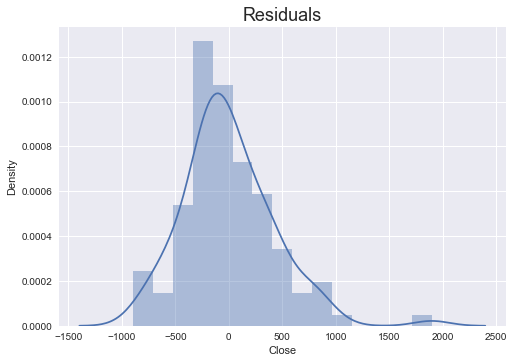

In [293]:
y_hat = lr.predict(X_train)
sns.distplot(y_train - y_hat)
plt.title("Residuals", size=18)
lr.score(X_train,y_train)

C:\Users\Aubrey\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


0.9689401703845689

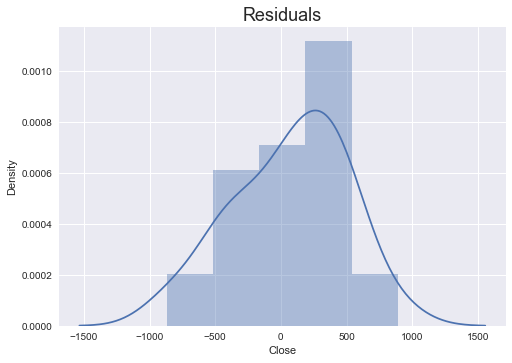

In [294]:
y_hat = lr.predict(X_test)
sns.distplot(y_test - y_hat)
plt.title("Residuals", size=18)
lr.score(X_test,y_test)

#### Decision Tree Regression
The decision trees is used to fit a sine curve with addition noisy observation. As a result, it learns local linear regressions approximating the sine curve.

If the maximum depth of the tree (controlled by the max_depth parameter) is set too high, the decision trees learn too fine details of the training data and learn from the noise, i.e. they overfit. Since we have only 4 variables used for predicting, we set the max_depth is 3.

In [304]:
from sklearn.tree import DecisionTreeRegressor

# instantiate the model 
tree = DecisionTreeRegressor(max_depth=3)
# fit the model 
tree.fit(X_train, y_train)

#predicting the target value from the model for the samples
y_test_tree = tree.predict(X_test)
y_train_tree = tree.predict(X_train)

#computing the accuracy of the model performance
acc_train_tree = tree.score(X_train, y_train)
acc_test_tree = tree.score(X_test, y_test)

#computing root mean squared error (RMSE)
rmse_train_tree = np.sqrt(mean_squared_error(y_train, y_train_tree))
rmse_test_tree = np.sqrt(mean_squared_error(y_test, y_test_tree))

print("Decision Tree: Accuracy on training Data: {:.3f}".format(acc_train_tree))
print("Decision Tree: Accuracy on test Data: {:.3f}".format(acc_test_tree))
print('\nDecision Tree: The RMSE/Close_index of the training set is:', rmse_train_tree/y_train.values.mean())
print('Decision Tree: The RMSE/Close_index of the testing set is:', rmse_test_tree/y_test.values.mean())

Decision Tree: Accuracy on training Data: 0.968
Decision Tree: Accuracy on test Data: 0.967

Decision Tree: The RMSE/Close_index of the training set is: 0.11093080606365531
Decision Tree: The RMSE/Close_index of the testing set is: 0.12203457958824461


[Text(223.2, 261.6075, 'X[0] <= 1843.31\nmse = 5795205.958\nsamples = 110\nvalue = 3908.919'),
 Text(111.6, 186.8625, 'X[1] <= 3185.36\nmse = 2335080.806\nsamples = 85\nvalue = 2868.321'),
 Text(55.8, 112.1175, 'X[2] <= 45.3\nmse = 226525.25\nsamples = 35\nvalue = 1222.182'),
 Text(27.9, 37.3725, 'mse = 96965.409\nsamples = 14\nvalue = 1718.389'),
 Text(83.69999999999999, 37.3725, 'mse = 39318.529\nsamples = 21\nvalue = 891.377'),
 Text(167.39999999999998, 112.1175, 'X[1] <= 4193.267\nmse = 586439.135\nsamples = 50\nvalue = 4020.618'),
 Text(139.5, 37.3725, 'mse = 593465.536\nsamples = 22\nvalue = 3431.134'),
 Text(195.29999999999998, 37.3725, 'mse = 93366.852\nsamples = 28\nvalue = 4483.784'),
 Text(334.79999999999995, 186.8625, 'X[0] <= 2400.405\nmse = 1360281.611\nsamples = 25\nvalue = 7446.952'),
 Text(279.0, 112.1175, 'X[0] <= 2089.375\nmse = 333104.046\nsamples = 18\nvalue = 6800.514'),
 Text(251.1, 37.3725, 'mse = 188222.093\nsamples = 10\nvalue = 6407.625'),
 Text(306.9, 37.372

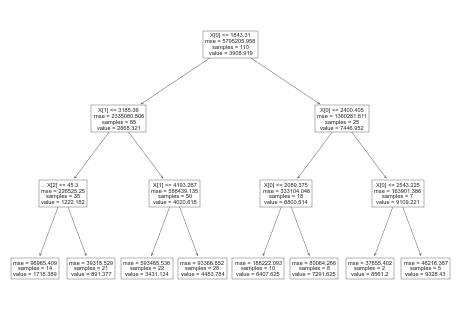

In [302]:
from sklearn.tree import plot_tree
plot_tree(tree)  

According to the values of Accuracy and RMSE/Close_index, the model performs well on both the training set and test set.

## 9. Conclusion
This tutorial aims to take us walk through a general Data Science Pipeline. A data science pipeline is the set of processes that convert raw data into actionable answers to business questions. It contains several core steps which have been illustrated in the prior sections. \
Recap the process, we first load the data from 5 different sources. Secondly, tidy the data by intergrating these tables. In this part, unite the data type and column names are highly important. Thridly, to deal with the missing values, we check for missing data (only INR/USD-Average	contains NaNs, and most of its values follow a linear increase or decrease) then fill them with linear interpolation. Fourly, use EDA approch to detect the relationship between each variables (*GDP PPP India*, *Real Interests Rate of India, The Exchange Rate between INR & USD*, and *S&P 500*) and the target feature (*Nifty 500*), check whether they are linear correlation or not. It turns out that *Nifty 500* and 3 variables (*GDP PPP India*, *The Exchange Rate between INR & USD*, and *S&P 500*) have highly possitive correlations. However, the relationship between *Nifty 500* and *Real Interests Rate of India* is weaker and negative. Fifth, according to the gains from EDA, we test if the linear correlations are true by performing Hypothesis testing. The result is that *Nifty 500* and 3 variables (*GDP PPP India*, *The Exchange Rate between INR & USD*, and *S&P 500*) are linear correlation, but *Nifty 500* and *Real Interests Rate of India*  is not linear correlation. Lastly, we build two regression models (LinearRegression and DecisionTree Regressor) to fit the training dataset and perform them on the test dataset. This shows that both models performed very well on the training set and the test set. That is to say, they have strong generalization ability, and there is no obvious over-fitting phenomenon.\
In gerneral, this tutorial is good example to explain the Data Science Pipeline. However, there are few more works we can do in the futher. For example, the time unit of some variables is year, so in order to expand the data set and refine the data granularity, we can collect data in units of days. There are always something more we could do during the the Data Science Process. Hope you enjoy this tutorial!

## 10. Reference
#### To check the detail of the datasets used in this tutorial:
A. NIFTY 500 Index (2000-2019) from https://www.kaggle.com/sudalairajkumar/nifty-indicesdataset?select=NIFTY+500.csv . We only need the close value column from the table. \
B. GDP PPP of India (2000-2019) from https://www.kaggle.com/nitishabharathi/gdp-percapita-all-countries. We only need the India row from the table. \
C. Real interest rate of India (2000-2019) from https://databank.worldbank.org/reports.aspx?
source=2&series=FR.INR.RINR&country=IND \
D. The exchange rate of the Indian Rupee(INR)(2000-2019) from https://
www.indiamacroadvisors.com/page/category/economic-indicators/financial-markets/
exchange-rate/ \
E. The S & P 500 Index (2000-2019) from https://datahub.io/core/s-and-p-500. We only need 
the SP500 column from the table. 

#### To learn more about a given topic check the following links:
[1] Decision Tree and its plots \
https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html \
[2] Linear Regression \
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html \
https://www.statsmodels.org/stable/examples/notebooks/generated/ols.html \
[3] Data Science Pipeline \
https://www.snowflake.com/guides/data-science-pipeline#:~:text=A%20data%20science%20pipeline%20is,insights%20for%20making%20business%20decisions.